# Customer Segmentation Analysis Using RFM (Recency, Frequency, & Monetary Value)

In [2]:
# import pytho modules for analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

## Step 2: Load dataset

In [3]:
# Specify the column(s) to be parsed as dates
parse_dates = ['InvoiceDate', 'InvoiceMonth']

# Specify the column(s) and their desired data types
dtype_dict = {
    'CustomerID': str
}

# Path to the dataset
dataset_path = "../dataset1-online-retail-enhanced.csv"

# Read the CSV file, parsing the specified columns as datetime and setting data types for others
dataset1_online_retail_enhanced = pd.read_csv(dataset_path, encoding='unicode_escape', parse_dates=parse_dates, dtype=dtype_dict)

# print shape of the data
print(f"Enhaced dataset shape: {dataset1_online_retail_enhanced.shape}")

# Display the first few rows of the dataset
dataset1_online_retail_enhanced.head()

Enhaced dataset shape: (397924, 12)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDateTime,UnitPrice,CustomerID,Country,InvoiceDate,InvoiceAmount,InvoiceDayOfWeek,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,15.30,Wednesday,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34,Wednesday,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,22.00,Wednesday,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34,Wednesday,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34,Wednesday,2010-12-01


In [4]:
dataset1_online_retail_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397924 entries, 0 to 397923
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         397924 non-null  int64         
 1   StockCode         397924 non-null  object        
 2   Description       397924 non-null  object        
 3   Quantity          397924 non-null  int64         
 4   InvoiceDateTime   397924 non-null  object        
 5   UnitPrice         397924 non-null  float64       
 6   CustomerID        397924 non-null  object        
 7   Country           397924 non-null  object        
 8   InvoiceDate       397924 non-null  datetime64[ns]
 9   InvoiceAmount     397924 non-null  float64       
 10  InvoiceDayOfWeek  397924 non-null  object        
 11  InvoiceMonth      397924 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(6)
memory usage: 36.4+ MB


## Step 3: Create RFM Table
1. Calculate Recency: The number of days since the customer's last purchase.
2. Calculate Frequency: The total number of purchases made by the customer.
3. Calculate Monetary: The total amount spent by the customer.

In [5]:
def create_rfm_table(df):
    # get daily cusomers 
    agg_customers_daily_sales_df = df.groupby(['CustomerID', 'Country', 'InvoiceDate']).agg(
        TotalInvoiceAmount = pd.NamedAgg(column='InvoiceAmount', aggfunc='sum')
    ).reset_index()
    # get first and last invoice date
    print(f"First Invoice Date: {agg_customers_daily_sales_df['InvoiceDate'].min()}")
    print(f"Last Invoice Date: {agg_customers_daily_sales_df['InvoiceDate'].max()}")

    # get today's date from the last invoice date
    todays_date = agg_customers_daily_sales_df['InvoiceDate'].max() + dt.timedelta(days=1)
    print(f"Today's Date: {todays_date}")

    # Calculate Recency, Frequency, and Monetary values
    rfm_table = agg_customers_daily_sales_df.groupby(['CustomerID', 'Country']).agg(
        Recency=pd.NamedAgg(column='InvoiceDate', aggfunc=lambda x: (todays_date - x.max()).days),
        Frequency=pd.NamedAgg(column='InvoiceDate', aggfunc='nunique'),
        MonetaryValue=pd.NamedAgg(column='TotalInvoiceAmount', aggfunc='sum')
    ).reset_index()

    print(f"RFM Table DataFrame Shape : {rfm_table.shape}")

    return rfm_table

# Perform RFM calculation on the dataset
rfm_table = create_rfm_table(dataset1_online_retail_enhanced)
rfm_table.head()

First Invoice Date: 2010-12-01 00:00:00
Last Invoice Date: 2011-12-09 00:00:00
Today's Date: 2011-12-10 00:00:00
RFM Table DataFrame Shape : (4347, 5)


,CustomerID,Country,Recency,Frequency,MonetaryValue
0,12346,United Kingdom,326,1,77183.60
1,12347,Iceland,3,7,4310.00
2,12348,Finland,76,4,1797.24
3,12349,Italy,19,1,1757.55
4,12350,Norway,311,1,334.40


### Explanation
- Here:
  - Get the _First Invoice Date_ and _Last Invoice Date_ from the dataset.
  -  We will use the _Last Sales Date_ in the calculation of __RECENCY__. 
  -  Create a Function to Define Recency and Tenure
     -  Recency is calculated using the InvoiceDate column to determine the number of days since the last purchase.
     -  Frequency is calculated using the InvoiceDate column to count the number of unique purchase dates.
     -  Monetary is calculated using the TotalInvoiceAmount column to sum the total amount spent.

## Step 4: Get RFM Segments
* The next thing we need to do is to segment the __recency__, __frequency__, and __total_value__ into the categories.
* For our use case, we can split each feature into 4 quartiles that roughly divide the sample into 4 segments of equal proportion. 
* We have called these scores __R__, __F__, and __M__ respectively.

To segment customers based on their RFM scores, we can divide each of the RFM metrics into quartiles. Customers will be assigned a score from 1 to 4 for each metric, with 4 being the highest (most recent, most frequent, highest monetary value) and 1 being the lowest. This segmentation will help in categorizing customers into different groups based on their purchasing behavior.

Here's how you can achieve this:
1. Calculate RFM Quartiles: Split the RFM metrics into quartiles and assign scores.
2. Combine RFM Scores: Create a combined RFM score for each customer.

In [6]:
def assign_rfm_scores(rfm_table):
    RFM_Segments = rfm_table

    # Recency Quartile Segmentation
    r_labels = range( 4, 0, -1)
    Recency = rfm_table['Recency']
    r_quartiles, bins = pd.qcut(Recency, 4, labels=r_labels, retbins=True)
    RFM_Segments = RFM_Segments.assign(R_Quartile = r_quartiles.values)

    # Frequency Quartile Segmentation
    f_labels = range(1, 5)
    Frequency = rfm_table['Frequency'].rank(method='first') # rank to deal with duplicate values
    f_quartiles, bins = pd.qcut(Frequency, 4, labels=f_labels, retbins=True)
    RFM_Segments = RFM_Segments.assign(F_Quartile = f_quartiles.values)

    # Monetary Value Quartile Segmentation
    m_labels = range(1, 5)
    MonetaryValue = rfm_table['MonetaryValue']
    m_quartiles, bins = pd.qcut(MonetaryValue, 4, labels=m_labels, retbins=True)
    RFM_Segments = RFM_Segments.assign(M_Quartile = m_quartiles.values)

    # 
    RFM_Segments['RFMClass'] = RFM_Segments["R_Quartile"].astype(str) + RFM_Segments["F_Quartile"].astype(str) + RFM_Segments['M_Quartile'].astype(str)
    RFM_Segments['RFMScore'] = RFM_Segments["R_Quartile"].astype(int) + RFM_Segments["F_Quartile"].astype(int) + RFM_Segments['M_Quartile'].astype(int)
    
    return RFM_Segments

# Apply the RFM segmentation
RFM_Segments = assign_rfm_scores(rfm_table)
RFM_Segments.head()

,CustomerID,Country,Recency,Frequency,MonetaryValue,R_Quartile,F_Quartile,M_Quartile,RFMClass,RFMScore
0,12346,United Kingdom,326,1,77183.60,1,1,4,114,6
1,12347,Iceland,3,7,4310.00,4,4,4,444,12
2,12348,Finland,76,4,1797.24,2,3,4,234,9
3,12349,Italy,19,1,1757.55,3,1,4,314,8
4,12350,Norway,311,1,334.40,1,1,2,112,4


### Explanations
#### Recency Quartile Segmentation:
- `r_labels`: This creates labels for the recency quartiles, ranging from 4 (most recent) to 1 (least recent).
- `Recency`: This extracts the Recency column from the rfm_table.
- `pd.qcut`: This function divides the Recency values into 4 quartiles based on their distribution. It assigns labels from r_labels and also returns the bin separators (bins) for future reference.
- `RFM_Segments.assign(R_Quartile = r_quartiles.values)`: This adds a new column named R_Quartile to the RFM_Segments DataFrame and assigns the calculated quartile values to it.

#### Frequency Quartile Segmentation
- Similar to recency, this section segments customers based on purchase frequency.
- `f_labels`: This creates labels for the frequency quartiles, ranging from 1 (least frequent) to 4 (most frequent).
- `Frequency.rank(method='first')`: This ranks the Frequency values. Ranking is used to handle cases where multiple customers might have the same frequency value. The method='first' ensures consistent ranking for ties.
- `pd.qcut` divides the ranked Frequency values into 4 quartiles with labels and bins.
- A new column `F_Quartile` is added to RFM_Segments and assigned the quartile values.

#### Monetary Value Quartile Segmentation:
- Similar to the previous sections, this segments customers based on their total monetary value.
- `m_labels`: This creates labels for the monetary value quartiles, ranging from 1 (lowest value) to 4 (highest value).
- `MonetaryValue`: This extracts the `MonetaryValue` column from the data.
- `pd.qcut` divides the MonetaryValue into 4 quartiles with labels and bins.
- A new column `M_Quartile` is added to `RFM_Segments` and assigned the quartile values.

### RFM Class and Score Calculation:
- `RFMClass`: This creates a new column named `RFMClass` by concatenating the string representations of the R, F, and M quartiles. This provides a combined RFM segment label (e.g., "432" for a customer in the highest recency quartile, 3rd frequency quartile, and 2nd monetary value quartile).
- `RFMScore`: This creates a new column named RFMScore by summing the integer representations of the R, F, and M quartiles. This provides a single score representing the overall RFM segmentation (e.g., 9 for the customer in the previous example).

## Step 5: Defining RFM Tiers
* We can further divide the customers into __RFM Tiers__ by binning together ranges of scores. 
* For example, we can say that customers with scores ranging from 3 to 5 are Bronze, from 5 to 9 are Silver and from 9 to 12 are Gold.

In [7]:
 # group customers into different Tiers
def get_tier(df):
    if df['RFMScore'] >= 9:
        return 'GOLD'
    elif (df['RFMScore'] >= 5) and (df['RFMScore'] < 9):
        return 'SILVER'
    else:
        return "BRONZE"
    
RFM_Segments['Tier'] = RFM_Segments.apply(get_tier, axis=1)
RFM_Segments

,CustomerID,Country,Recency,Frequency,MonetaryValue,R_Quartile,F_Quartile,M_Quartile,RFMClass,RFMScore,Tier
0,12346,United Kingdom,326,1,77183.60,1,1,4,114,6,SILVER
1,12347,Iceland,3,7,4310.00,4,4,4,444,12,GOLD
2,12348,Finland,76,4,1797.24,2,3,4,234,9,GOLD
3,12349,Italy,19,1,1757.55,3,1,4,314,8,SILVER
4,12350,Norway,311,1,334.40,1,1,2,112,4,BRONZE
...,...,...,...,...,...,...,...,...,...,...,...
4342,18280,United Kingdom,278,1,180.60,1,2,1,121,4,BRONZE
4343,18281,United Kingdom,181,1,80.82,1,2,1,121,4,BRONZE
4344,18282,United Kingdom,8,2,178.05,4,3,1,431,8,SILVER
4345,18283,United Kingdom,4,14,2094.88,4,4,4,444,12,GOLD


## Step 6: Get Distribution of Customers under Different Tiers

In [8]:
RFM_Segments['Tier'].value_counts()

Tier
SILVER    1855
GOLD      1682
BRONZE     810
Name: count, dtype: int64

## Step 7: Check For Feature Correlations

In [11]:
def get_feature_correlation(df):
    rfm_table_df = df[['CustomerID', 'Recency', 'Frequency', 'MonetaryValue']]
    rfm_table_df.set_index('CustomerID', inplace=True)

    # generate a featire correlation matrix
    rfm_corr = rfm_table_df.corr()
    return rfm_corr
get_feature_correlation(RFM_Segments)

,Recency,Frequency,MonetaryValue
Recency,1.000000,-0.297486,-0.122215
Frequency,-0.297486,1.000000,0.494284
MonetaryValue,-0.122215,0.494284,1.000000


### Correlation Coefficients Explained
- Correlation Coefficient (r):
  - Ranges from -1 to 1.
  - 1: Perfect positive correlation (as one variable increases, the other also increases).
  - -1: Perfect negative correlation (as one variable increases, the other decreases).
  - 0: No correlation (no linear relationship between the variables).

## Step 8: Generate and Plot the Heatmap

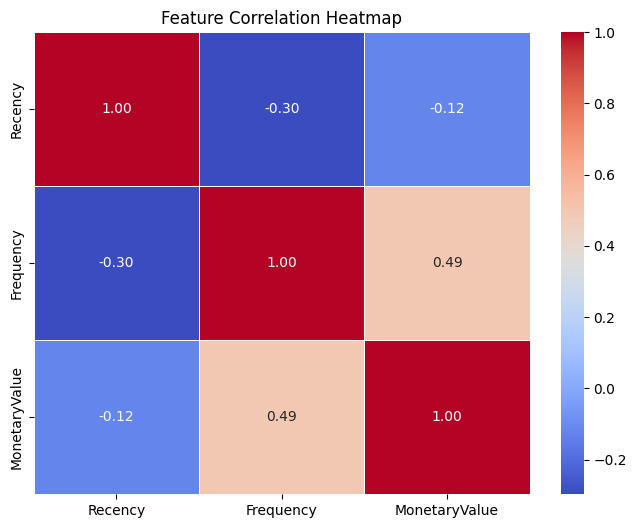

In [13]:
def plot_feature_correlation_heatmap(df, features):
    """
    Function to plot a heatmap of feature correlations.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the features to be correlated.
    features (list): A list of feature names to include in the correlation matrix.

    Returns:
    None
    """
    # Create the feature correlation matrix
    correlation_matrix = df[features].corr()

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title('Feature Correlation Heatmap')
    plt.show()

# Example usage
features = ['Recency', 'Frequency', 'MonetaryValue']
plot_feature_correlation_heatmap(RFM_Segments, features)

### Explanations
1. Recency (R) and Frequency (F): -0.3
   - Interpretation: There is a moderate negative correlation between Recency and Frequency. This suggests that, generally, as the Recency score increases (i.e., customers are less recent), the Frequency score tends to decrease. In other words, customers who haven’t purchased recently tend to purchase less frequently. 
2. Recency (R) and Monetary Value (M): -0.12
   - Interpretation: There is a weak negative correlation between Recency and Monetary Value. This indicates a slight tendency for customers who haven’t purchased recently to have a somewhat lower total monetary value. However, the relationship is weak, meaning that Recency does not strongly affect the amount spent by customers.
3. Frequency (F) and Monetary Value (M): 0.49
   - Interpretation: There is a moderate positive correlation between Frequency and Monetary Value. This suggests that customers who make purchases more frequently also tend to spend more in total. This is a common pattern where frequent buyers contribute significantly to the overall revenue.
4. Recency (R) and Frequency (F): -0.3
   - This is the same as the first correlation mentioned, so the interpretation remains the same: a moderate negative correlation indicating that less recent customers tend to have lower frequency scores.   